![birdclef](https://storage.googleapis.com/kaggle-competitions/kaggle/25954/logos/header.png?t=2021-03-19-18-32-57)

# BirdCLEF 2021 – Audio Classification

## Background

The Cornell Lab of Ornithology estimates about 10,000 bird species throughout the world. In addition to their relatively high position in the food chain, this makes birds great informants of air quality and biodiversity in various ecosystems. The identification of birds in their habitats is especially helpful for researchers and ornithological experts to implement conservation efforts.

Machine learning, particularly deep learning, has been helpful in bolstering acoustic data collection. Models to date, however, have presented inconsistencies in precision and recall abilities.

Source: [BirdCLEF 2021 Kaggle Competition](https://www.kaggle.com/c/birdclef-2021)

## Objective

This project seeks to implement deep learning techniques to identify bird species captured in audio recordings. Multiple model architectures are constructed and compared against each other for accuracy, precision, recall, and F1 scores.

## Data

The data was obtained from the [BirdCLEF 2021](https://www.kaggle.com/c/birdclef-2021) Kaggle competition.

## Imports

In [32]:
##### core operations
import numpy as np
import pandas as pd
import os
from tqdm import tqdm #progress bar

#audio and image processing libraries
import soundfile as sf
import librosa
import librosa.display as display
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

#sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix

#deep learning modules
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import (Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPool1D, MaxPool2D,
BatchNormalization, TimeDistributed, LayerNormalization, Bidirectional, Activation)
from keras.optimizers import Adam
from keras.applications import VGG19, VGG16, ResNet50
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1, l2

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

#warnings
import warnings
warnings.filterwarnings("ignore")

## Functions, Classes, and Variables

In [2]:
# Global Coefficients that can be modified
class coefs:
    """
    Class of coefficients defined with values for future operations.
    """
    # Generate Subset
    rat_id = 4 # rating subset limiter 
    recs = 200 # each specie must have X recodings
    max_files = 3000 # general last limit for rows
    thresh = 0.25 # label probability selection threshold
    submission = True # For Submission Only (Less Inference Output)
    
    # Global vars
    seed = 1234
    sr = 16000        # librosa sample rate input
    sl = 5 # seconds   
    sshape = (48,128) # height x width
    fmin = 500      # spectrum min frequency
    fmax = 12500    # spectrum max frequency
    n_epoch = 100   # training epochs
    cutoff = 15     # 3 sample spectogram (training) overwritten for inference

path_switch = False

Source code for above class: [DrCapa](https://www.kaggle.com/drcapa/birdclef-2021-starter)

In [191]:
def read_ogg_file(path, file):
    """
    Read .ogg audio file via SoundFile. Returns numpy array of audio file and samplerate.
    """
    
    vdata, samplerate = sf.read(path+file)
    return data, samplerate

def plot_audio_file(data, samplerate):
    """
    Displays wave form of audio file.
    """
    sr = samplerate
    fig = plt.figure(figsize=(8, 4))
    x = range(len(data))
    y = data
    plt.plot(x, y)
    plt.plot(x, y, color='blue')
    plt.legend(loc='upper center')
    plt.grid()
    
def plot_signals(signals):
    fig, axes = plt.subplots(nrows=7, ncols=4, sharex=False,
                             sharey=True, figsize=(20,15))
    fig.suptitle('Time Series', size=16)
    i = 0
    for x in range(7):
        for y in range(4):
            axes[x,y].set_title(list(signals.keys())[i])
            axes[x,y].plot(list(signals.values())[i])
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1
    
def get_spectrograms(filepath, primary_label, output_dir):
    """
    Inputs path to audio file. Performs short-time fourier transformation (STFT) and
    outputs mel spectrogram, a visual representation of the audio's physical properties
    (i.e., frequency, amplitude) over time.
    """
    # Open the file with librosa (limited to the first 15 seconds)
    sig, rate = librosa.load(filepath, sr=SAMPLE_RATE, offset=None, duration=15)
    
    # Split signal into five second chunks
    sig_splits = []
    for i in range(0, len(sig), int(SIGNAL_LENGTH * SAMPLE_RATE)):
        split = sig[i:i + int(SIGNAL_LENGTH * SAMPLE_RATE)]

        # End of signal?
        if len(split) < int(SIGNAL_LENGTH * SAMPLE_RATE):
            break
        
        sig_splits.append(split)
        
    # Extract mel spectrograms for each audio chunk
    s_cnt = 0
    saved_samples = []
    for chunk in sig_splits:
        
        hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y=chunk, 
                                                  sr=SAMPLE_RATE, 
                                                  n_fft=1024, 
                                                  hop_length=hop_length, 
                                                  n_mels=SPEC_SHAPE[0], 
                                                  fmin=FMIN, 
                                                  fmax=FMAX)
    
        mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 
        
        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Save as image file
        save_dir = os.path.join(output_dir, primary_label)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = os.path.join(save_dir, filepath.rsplit(os.sep, 1)[-1].rsplit('.', 1)[0] + 
                                 '_' + str(s_cnt) + '.png')
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(save_path)
        
        saved_samples.append(save_path)
        s_cnt += 1
        
    return saved_samples

def plot_spectrogram(data, samplerate):
    """ Plot spectrogram with mel scaling in time domain. """
    sr = samplerate
    spectrogram = librosa.feature.melspectrogram(data, sr=sr)
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel')
    
def make_bar_chart(df, column):
    """
    Function that inputs column name and outputs the frequency of its classes as a bar chart.
    """
    val_cts = df[column].value_counts()

    # Make bar chart
    fig = go.Figure(data=[go.Bar(y=val_cts.values, x=val_cts.index)],
                    layout=go.Layout(margin=go.layout.Margin(l=0, r=0, b=70, t=50)))

    # Show chart
    fig.update_layout(title=f"Number of samples for {column}")
    fig.show()
    
def get_map(df):
    
    """
    Takes in dataframe and outputs map of audio recording locations. Dataframe is either original 
    (train_metadata.csv) or a subset. Column names are constant. Displays below information with hover.
    """
    
    fig = px.scatter_mapbox(df, lat="latitude", lon="longitude", hover_name="common_name", 
                        hover_data=["primary_label", "scientific_name", "date"],
                        color_discrete_sequence=["palevioletred"], zoom=1, width=1050, height=650)
    fig.update_layout(
        mapbox_style="white-bg",
        mapbox_layers=[
            {
                "below": 'traces',
                "sourcetype": "raster",
                "sourceattribution": "United States Geological Survey",
                "source": [
                    "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
                ]
            }
        ])
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.show()
    
def visualize_training_results(results):
    """
    Displays training loss and accuracy metrics across epochs.
    """
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Directories and Datasets

In [4]:
#create main directory variable
MAIN_DIR = '/kaggle/input/birdclef-2021/'
os.listdir(MAIN_DIR)

['train_soundscape_labels.csv',
 'sample_submission.csv',
 'train_soundscapes',
 'train_short_audio',
 'test.csv',
 'train_metadata.csv',
 'test_soundscapes']

In [5]:
train_labels = pd.read_csv(MAIN_DIR+'train_soundscape_labels.csv')
train_meta = pd.read_csv(MAIN_DIR+'train_metadata.csv')
test_data = pd.read_csv(MAIN_DIR+'test.csv')
samp_subm = pd.read_csv(MAIN_DIR+'sample_submission.csv')

In [6]:
print('Number train label samples:', len(train_labels))
print('Number train meta samples:', len(train_meta))
print('Number train short folder:', len(os.listdir(MAIN_DIR+'train_short_audio')))
print('Number train audios:', len(os.listdir(MAIN_DIR+'train_soundscapes')))
print('Number test samples:', len(test_data))

Number train label samples: 2400
Number train meta samples: 62874
Number train short folder: 397
Number train audios: 20
Number test samples: 3


In [7]:
train_labels.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [8]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    2400 non-null   object
 1   site      2400 non-null   object
 2   audio_id  2400 non-null   int64 
 3   seconds   2400 non-null   int64 
 4   birds     2400 non-null   object
dtypes: int64(2), object(3)
memory usage: 93.9+ KB


In [9]:
train_meta.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
0,acafly,['amegfi'],"['begging call', 'call', 'juvenile']",35.3860,-84.1250,Empidonax virescens,Acadian Flycatcher,Mike Nelson,2012-08-12,XC109605.ogg,Creative Commons Attribution-NonCommercial-Sha...,2.5,09:30,https://www.xeno-canto.org/109605
1,acafly,[],['call'],9.1334,-79.6501,Empidonax virescens,Acadian Flycatcher,Allen T. Chartier,2000-12-26,XC11209.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,?,https://www.xeno-canto.org/11209
2,acafly,[],['call'],5.7813,-75.7452,Empidonax virescens,Acadian Flycatcher,Sergio Chaparro-Herrera,2012-01-10,XC127032.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.0,15:20,https://www.xeno-canto.org/127032
3,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129974.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129974
4,acafly,['whwbec1'],['call'],4.6717,-75.6283,Empidonax virescens,Acadian Flycatcher,Oscar Humberto Marin-Gomez,2009-06-19,XC129981.ogg,Creative Commons Attribution-NonCommercial-Sha...,3.5,07:50,https://www.xeno-canto.org/129981


In [10]:
train_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62874 entries, 0 to 62873
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     62874 non-null  object 
 1   secondary_labels  62874 non-null  object 
 2   type              62874 non-null  object 
 3   latitude          62874 non-null  float64
 4   longitude         62874 non-null  float64
 5   scientific_name   62874 non-null  object 
 6   common_name       62874 non-null  object 
 7   author            62874 non-null  object 
 8   date              62874 non-null  object 
 9   filename          62874 non-null  object 
 10  license           62874 non-null  object 
 11  rating            62874 non-null  float64
 12  time              62874 non-null  object 
 13  url               62874 non-null  object 
dtypes: float64(3), object(11)
memory usage: 6.7+ MB


In [11]:
test_data

,row_id,site,audio_id,seconds
0,3575_COL_5,COL,3575,5
1,3575_COL_10,COL,3575,10
2,3575_COL_15,COL,3575,15


## Distribution of Data

In [12]:
make_bar_chart(train_meta, 'primary_label')

In order to mitigate model training issues related to class imbalance, the below code filters out data based on two criteria:

- **Quantity of recordings per spcies:** A minimum of 200 recordings per species.
- **Quality of recording:** Ratings of 4 and above.

In [13]:
# Load metadata file
train = pd.read_csv('../input/birdclef-2021/train_metadata.csv',)

# Limit the number of training samples and classes
# First, only use high quality samples
train = train.query('rating>=4')

# Second, assume that birds with the most training samples are also the most common
# A species needs at least 200 recordings with a rating above 4 to be considered common
birds_count = {}
for bird_species, count in zip(train.primary_label.unique(), 
                               train.groupby('primary_label')['primary_label'].count().values):
    birds_count[bird_species] = count
most_represented_birds = [key for key,value in birds_count.items() if value >= 200] 

TRAIN = train.query('primary_label in @most_represented_birds')
LABELS = sorted(TRAIN.primary_label.unique())

# Let's see how many species and samples we have left
print('NUMBER OF SPECIES IN TRAIN DATA:', len(LABELS))
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(TRAIN))
print('LABELS:', most_represented_birds)

NUMBER OF SPECIES IN TRAIN DATA: 27
NUMBER OF SAMPLES IN TRAIN DATA: 8548
LABELS: ['amerob', 'barswa', 'bewwre', 'blujay', 'bncfly', 'carwre', 'compau', 'comrav', 'comyel', 'eursta', 'gbwwre1', 'grekis', 'houspa', 'houwre', 'mallar3', 'norcar', 'normoc', 'redcro', 'rewbla', 'roahaw', 'rubpep1', 'rucspa1', 'sonspa', 'spotow', 'wbwwre1', 'wesmea', 'yeofly1']


Source for above code: [Francois Lemarchand](https://www.kaggle.com/frlemarchand/bird-song-classification-using-an-efficientnet)

In [14]:
TRAIN.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url
1466,amerob,[],['call'],43.0770,-96.1700,Turdus migratorius,American Robin,Jonathon Jongsma,2012-06-23,XC107523.ogg,Creative Commons Attribution-ShareAlike 3.0,4.0,21:00,https://www.xeno-canto.org/107523
1467,amerob,[],['flight call'],44.9420,-93.2590,Turdus migratorius,American Robin,Jonathon Jongsma,2012-10-30,XC112597.ogg,Creative Commons Attribution-ShareAlike 3.0,4.0,14:00,https://www.xeno-canto.org/112597
1471,amerob,[],['song'],43.0802,-96.1643,Turdus migratorius,American Robin,Jonathon Jongsma,2013-04-03,XC128490.ogg,Creative Commons Attribution-ShareAlike 3.0,5.0,06:22,https://www.xeno-canto.org/128490
1473,amerob,"['mallar3', 'comyel']",['song'],35.0307,-120.6205,Turdus migratorius,American Robin,Thomas G. Graves,2013-04-14,XC129798.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.5,7:47,https://www.xeno-canto.org/129798
1477,amerob,"['norcar', 'rewbla', 'comgra', 'amecro', 'bluj...",['call'],43.0770,-96.1700,Turdus migratorius,American Robin,Jonathon Jongsma,2013-04-20,XC131093.ogg,Creative Commons Attribution-ShareAlike 3.0,4.5,06:38,https://www.xeno-canto.org/131093


In [17]:
row = 0
TRAIN.iloc[row]

primary_label                                            amerob
secondary_labels                                             []
type                                                   ['call']
latitude                                                 43.077
longitude                                                -96.17
scientific_name                              Turdus migratorius
common_name                                      American Robin
author                                         Jonathon Jongsma
date                                                 2012-06-23
filename                                           XC107523.ogg
license             Creative Commons Attribution-ShareAlike 3.0
rating                                                      4.0
time                                                      21:00
url                           https://www.xeno-canto.org/107523
class_id                                                      0
Name: 1466, dtype: object

In [18]:
make_bar_chart(TRAIN, 'primary_label')

In [78]:
classes = list(TRAIN['primary_label'].unique())
classes

['blujay',
 'comyel',
 'amerob',
 'normoc',
 'gbwwre1',
 'compau',
 'houspa',
 'houwre',
 'mallar3',
 'rewbla',
 'comrav',
 'bncfly',
 'wesmea',
 'rucspa1',
 'sonspa',
 'wbwwre1',
 'norcar',
 'redcro',
 'spotow',
 'rubpep1',
 'yeofly1',
 'eursta',
 'grekis',
 'bewwre',
 'barswa',
 'roahaw',
 'carwre']

In [19]:
get_map(TRAIN)

## Representations of Audio Data

In [165]:
filenames = [f for f in TRAIN['filename']]
filenames

['XC168657.ogg',
 'XC326770.ogg',
 'XC416294.ogg',
 'XC320710.ogg',
 'XC517997.ogg',
 'XC403926.ogg',
 'XC571245.ogg',
 'XC544559.ogg',
 'XC336062.ogg',
 'XC37508.ogg',
 'XC141760.ogg',
 'XC321906.ogg',
 'XC385668.ogg',
 'XC469605.ogg',
 'XC441516.ogg',
 'XC510710.ogg',
 'XC432833.ogg',
 'XC509726.ogg',
 'XC555834.ogg',
 'XC570128.ogg',
 'XC155235.ogg',
 'XC421278.ogg',
 'XC396464.ogg',
 'XC532524.ogg',
 'XC480068.ogg',
 'XC509346.ogg',
 'XC559516.ogg',
 'XC123615.ogg',
 'XC235824.ogg',
 'XC343880.ogg',
 'XC573145.ogg',
 'XC375798.ogg',
 'XC415386.ogg',
 'XC517990.ogg',
 'XC377077.ogg',
 'XC248103.ogg',
 'XC454930.ogg',
 'XC370494.ogg',
 'XC459590.ogg',
 'XC196391.ogg',
 'XC148256.ogg',
 'XC127302.ogg',
 'XC462593.ogg',
 'XC391254.ogg',
 'XC409373.ogg',
 'XC80524.ogg',
 'XC359195.ogg',
 'XC206757.ogg',
 'XC307683.ogg',
 'XC570932.ogg',
 'XC351049.ogg',
 'XC143436.ogg',
 'XC564291.ogg',
 'XC501839.ogg',
 'XC598439.ogg',
 'XC149412.ogg',
 'XC558390.ogg',
 'XC267651.ogg',
 'XC332391.ogg',

In [20]:
label = TRAIN.loc[1466, 'primary_label']
filename = TRAIN.loc[1466, 'filename']

# Check if the file is in the folder
filename in os.listdir(MAIN_DIR+'train_short_audio/'+label)

True

In [21]:
data, samplerate = sf.read(MAIN_DIR+'train_short_audio/'+label+'/'+filename)
print(f"Label: {label}")
print(f"File name: {filename}")
print(f"Sample rate: {samplerate}")

Label: amerob
File name: XC107523.ogg
Sample rate: 32000


Below are three representations of the above audio file: **./amerob/XC107523.ogg**

### Audio

A single .ogg file output by librosa. 

In [22]:
for c in classes:
    audio_file = TRAIN[TRAIN['primary_label'] == c].iloc[0,9]

### Waveform

Samples of waveforms for each class.

IndexError: list index out of range

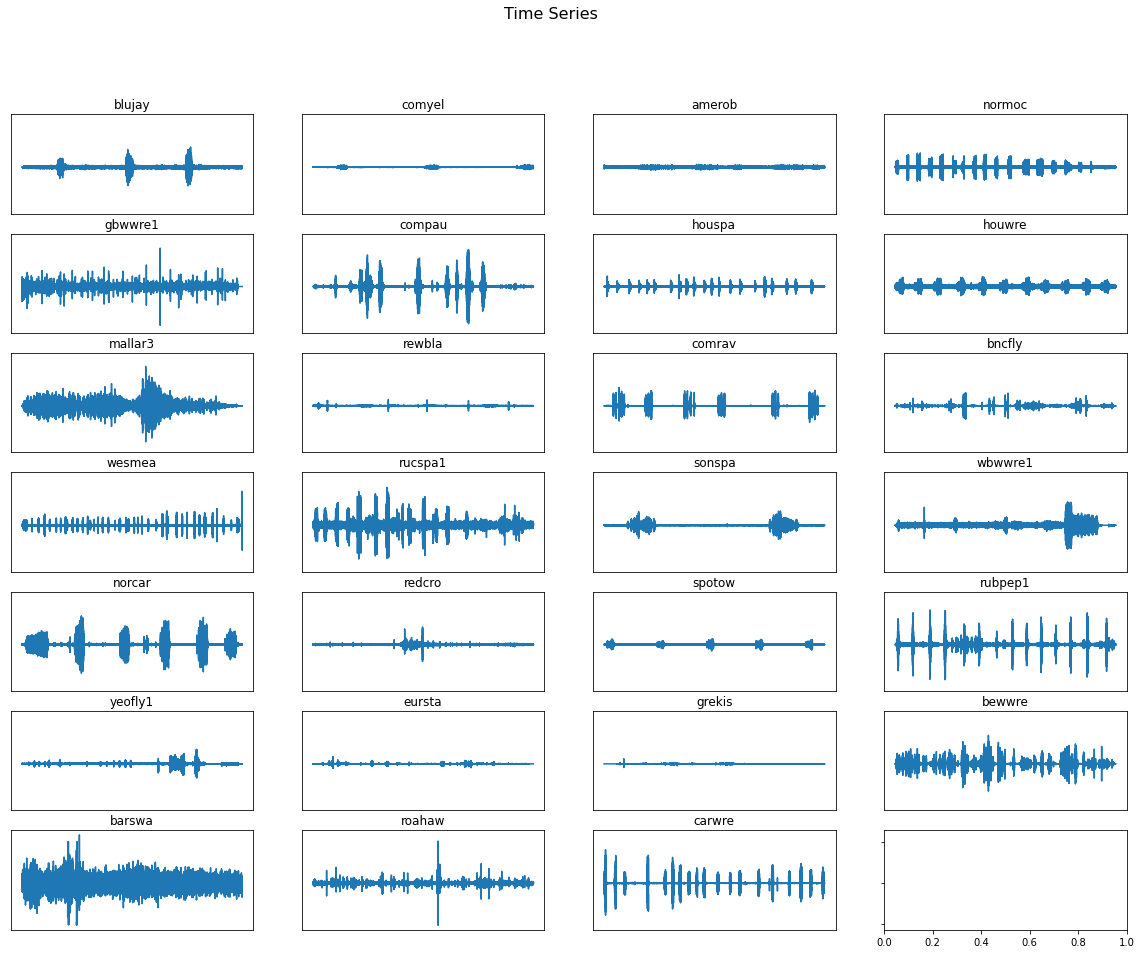

In [192]:
sig = {}

for c in classes:
    audio_file = TRAIN[TRAIN['primary_label'] == c].iloc[0,9]
    signal, rate = librosa.load(MAIN_DIR+'train_short_audio/'+c+'/'+audio_file, sr=16000)
    sig[c] = signal

plot_signals(sig)

### Mel Spectrogram

A visual representation of the audio file as frequency over time. The brighter colors represent higher levels of amplitude.

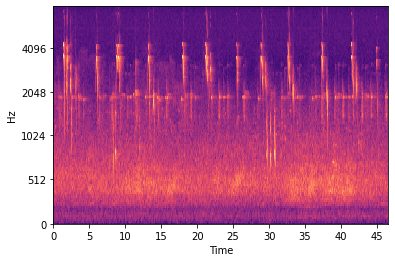

In [86]:
plot_spectrogram(data, coefs.sr)

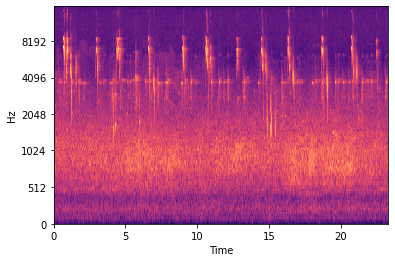

In [87]:
plot_spectrogram(data, samplerate)

## Data Transformation and Generation

### Envelope

Utilizing the below function to remove any "dead space" of the audio files.

In [74]:
def envelope(signal, rate, threshold):
    mask = []
    signal = pd.Series(signal).apply(np.abs) # Convert to series to find rolling average and apply absolute value to the signal at all points. 
    signal_mean = signal.rolling(window = int(rate/10), min_periods = 1, center = True).mean() # Take the rolling average of the series within our specified window.
    
    for mean in signal_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return np.array(mask)

In [157]:
[c for c in classes]

['blujay',
 'comyel',
 'amerob',
 'normoc',
 'gbwwre1',
 'compau',
 'houspa',
 'houwre',
 'mallar3',
 'rewbla',
 'comrav',
 'bncfly',
 'wesmea',
 'rucspa1',
 'sonspa',
 'wbwwre1',
 'norcar',
 'redcro',
 'spotow',
 'rubpep1',
 'yeofly1',
 'eursta',
 'grekis',
 'bewwre',
 'barswa',
 'roahaw',
 'carwre']

In [174]:
TRAIN.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,class_id
8252,blujay,[],['call'],40.870800,-73.539800,Cyanocitta cristata,Blue Jay,Albert & Max Lastukhin,2014-03-03,XC168657.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,12:00,https://www.xeno-canto.org/168657,3
18106,comyel,[],['song'],52.188100,-122.070500,Geothlypis trichas,Common Yellowthroat,Phil Ranson,2016-07-07,XC326770.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,08:30,https://www.xeno-canto.org/326770,8
1738,amerob,[],['song'],35.289100,-82.434500,Turdus migratorius,American Robin,Gary Harbour,2018-05-21,XC416294.ogg,Creative Commons Attribution-NonCommercial-Sha...,5.0,12:00,https://www.xeno-canto.org/416294,0
36643,normoc,[],"['male', 'nocturnal', 'song']",32.504800,-93.703600,Mimus polyglottos,Northern Mockingbird,Terry Davis,2015-05-25,XC320710.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,01:15,https://www.xeno-canto.org/320710,16
23563,gbwwre1,[],[''],7.425278,-72.443889,Henicorhina leucophrys,Gray-breasted Wood-Wren,Mauricio Álvarez-Rebolledo (Colección de Sonid...,1999-06-23,XC517997.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,?,https://www.xeno-canto.org/517997,10


In [173]:
TRAIN[TRAIN['filename'] == 'XC168657.ogg']

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,date,filename,license,rating,time,url,class_id
8252,blujay,[],['call'],40.8708,-73.5398,Cyanocitta cristata,Blue Jay,Albert & Max Lastukhin,2014-03-03,XC168657.ogg,Creative Commons Attribution-NonCommercial-Sha...,4.0,12:00,https://www.xeno-canto.org/168657,3


IndexError: list index out of range

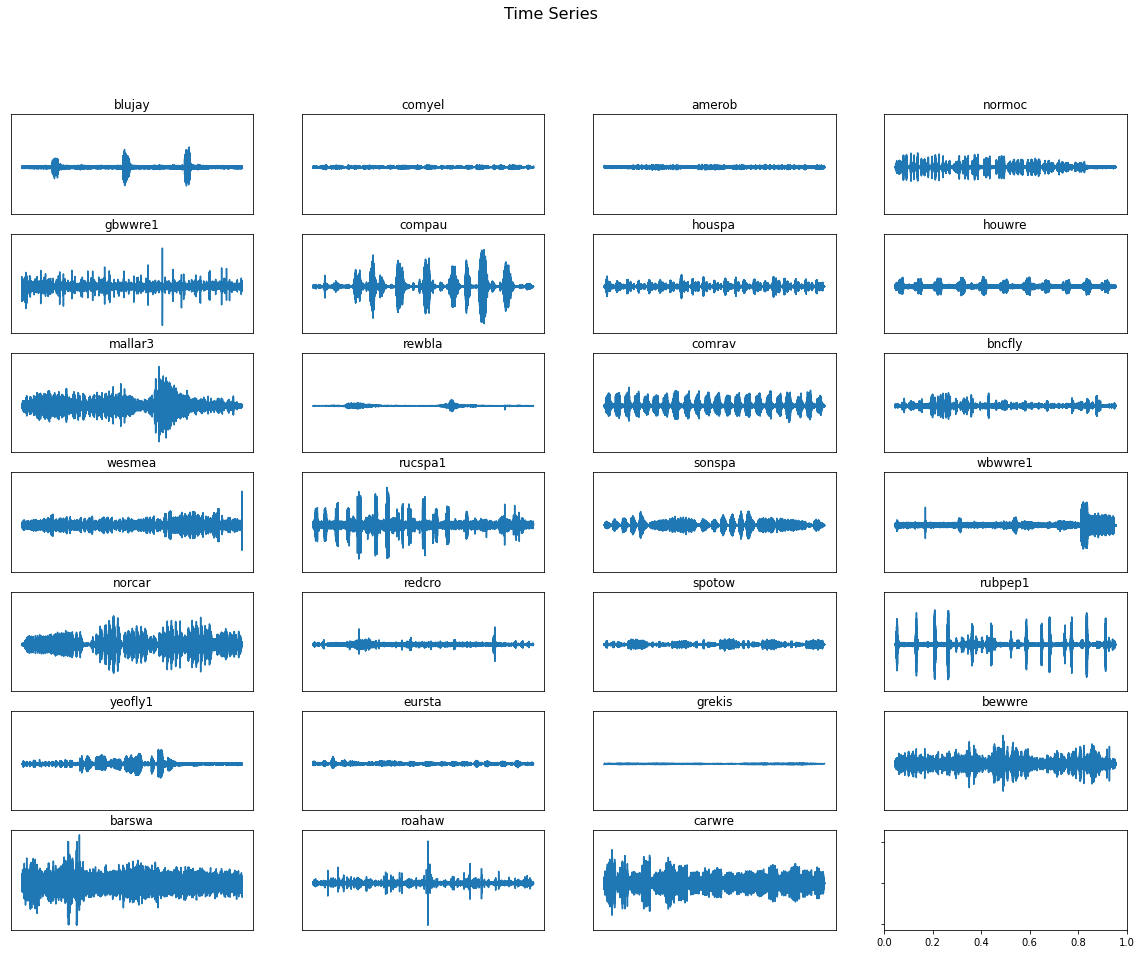

In [196]:
sig_new = {}

# Clean displayed audio from above.
for c in classes:
    audio_file = TRAIN[TRAIN['primary_label'] == c].iloc[0,9]
    signal, rate = librosa.load(MAIN_DIR+'train_short_audio/'+c+'/'+audio_file, sr=16000)
    mask = envelope(signal, rate, 0.0075)
    signal = signal[mask]
    sig_new[c] = signal

plot_signals(sig_new)

In [178]:
def fft_calc(y, rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d=(1/rate))
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

In [182]:
fft = {}

for c in classes:
    fft[c] = fft_calc(sig_new, coefs.sr)

fft

AxisError: axis -1 is out of bounds for array of dimension 0

In [147]:
def plot_fft(fft):
    fig, axes = plt.subplots(nrows=5, ncols=5, sharex=False,
                             sharey=True, figsize=(20,12))
    fig.suptitle('Fourier Transforms', size=16)
    i = 0
    for x in range(5):
        for y in range(5):
            data = list(fft.values())[i]
            Y, freq = data[0], data[1]
            axes[x,y].set_title(list(fft.keys())[i])
            axes[x,y].plot(freq, Y)
            axes[x,y].get_xaxis().set_visible(False)
            axes[x,y].get_yaxis().set_visible(False)
            i += 1

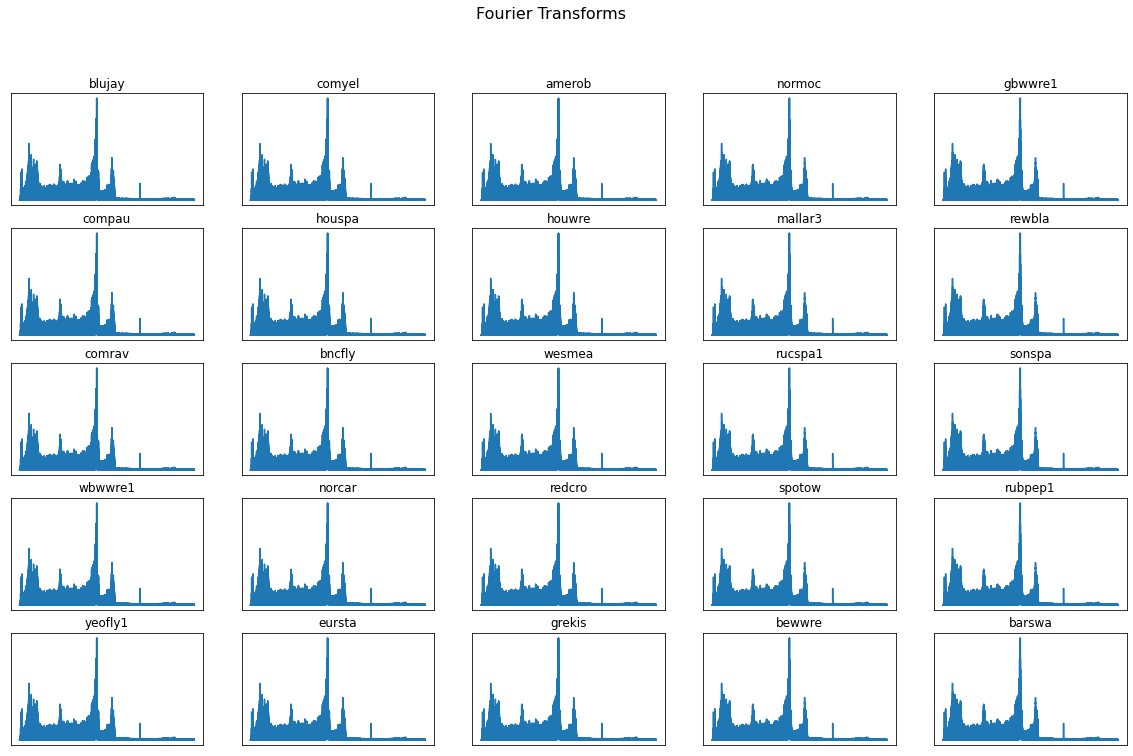

In [148]:
plot_fft(fft)

In [139]:
plot_spectrogram(fft, 16000)

ParameterError: Audio data must be of type numpy.ndarray

In [34]:
# Shuffle the training data and limit the number of audio files to MAX_AUDIO_FILES
RANDOM_SEED = 123
SAMPLE_RATE = 16000
SIGNAL_LENGTH = 5 # seconds
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500
MAX_AUDIO_FILES = 1500

TRAIN = shuffle(TRAIN, random_state=RANDOM_SEED)[:MAX_AUDIO_FILES]

In [36]:
audio_dir = '../input/birdclef-2021/train_short_audio/'
output_dir = '../working/melspectrogram_dataset/'
samples = []
with tqdm(total=len(TRAIN)) as pbar:
    for idx, row in TRAIN.iterrows():
        pbar.update(1)
        
        if row.primary_label in most_represented_birds:
            audio_file_path = os.path.join(audio_dir, row.primary_label, row.filename)
            samples += get_spectrograms(audio_file_path, row.primary_label, output_dir)
            
TRAIN_SPECS = shuffle(samples, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS'.format(len(TRAIN_SPECS)))

100%|██████████| 1500/1500 [12:41<00:00,  1.97it/s]

SUCCESSFULLY EXTRACTED 4124 SPECTROGRAMS


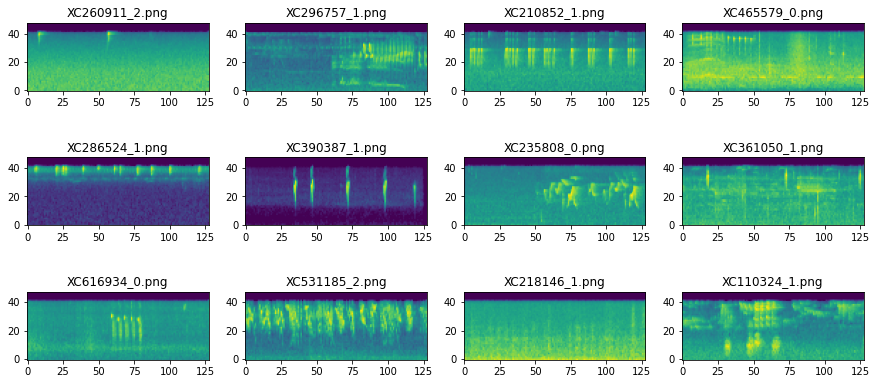

In [37]:
# Plot the first 12 log spectrograms of TRAIN_SPECS
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(TRAIN_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TRAIN_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

In [38]:
train_labels['audio_id'].unique()
print(f"Number of unique birds: {len(train_labels['audio_id'].unique())}")

Number of unique birds: 20


In [39]:
train_labels.groupby(by=['audio_id']).count()['birds'][:4]

audio_id
2782    120
7019    120
7843    120
7954    120
Name: birds, dtype: int64

In [40]:
parsed_labels = train_labels
parsed_labels.head()

,row_id,site,audio_id,seconds,birds
0,7019_COR_5,COR,7019,5,nocall
1,7019_COR_10,COR,7019,10,nocall
2,7019_COR_15,COR,7019,15,nocall
3,7019_COR_20,COR,7019,20,nocall
4,7019_COR_25,COR,7019,25,nocall


In [41]:
# Parse all samples and add spectrograms into train data, primary_labels into label data
specs, labels = [], []
with tqdm(total=len(TRAIN_SPECS)) as pbar:
    for path in TRAIN_SPECS:
        pbar.update(1)

        # Open image
        spec = Image.open(path)

        # Convert to numpy array
        spec = np.array(spec, dtype='float32')
        
        # Normalize between 0.0 and 1.0
        # and exclude samples with nan 
        spec -= spec.min()
        spec /= spec.max()
        if not spec.max() == 1.0 or not spec.min() == 0.0:
            continue

        # Add channel axis to 2D array
        spec = np.expand_dims(spec, -1)

        # Add new dimension for batch size
        spec = np.expand_dims(spec, 0)

        # Add to train data
        if len(specs) == 0:
            specs = spec
        else:
            specs = np.vstack((specs, spec))

        # Add to label data
        target = np.zeros((len(LABELS)), dtype='float32')
        bird = path.split(os.sep)[-2]
        target[LABELS.index(bird)] = 1.0
        if len(labels) == 0:
            labels = target
        else:
            labels = np.vstack((labels, target))

100%|██████████| 4124/4124 [01:12<00:00, 57.03it/s] 


### Display Samples

Spectrograms of audio clips downsampled to 16kHz and reshaped to mono (1 channel).

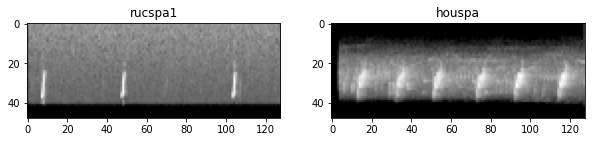

In [42]:
for r in os.listdir("./melspectrogram_dataset/rucspa1/"):
    img_rucspa1 = load_img(("./melspectrogram_dataset/rucspa1/") + r)

for h in os.listdir("./melspectrogram_dataset/houspa/"):
    img_houspa = load_img("./melspectrogram_dataset/houspa/" + h)
    
fig, axs = plt.subplots(1,2,figsize=(10,6))
axs[0].imshow(img_rucspa1)
axs[0].set_title("rucspa1")
axs[1].imshow(img_houspa)
axs[1].set_title("houspa");

### Train-Test Split

In [43]:
train_specs, test_specs, train_labels, test_labels = train_test_split(specs, labels, test_size=0.2)

In [44]:
print(f"Train Spectrogram Shape:{train_specs.shape}")
print(f"Test Spectrogram Shape:{test_specs.shape}")
print('\n')
print(f"Train Labels Shape:{train_labels.shape}")
print(f"Test Labels Shape:{test_labels.shape}")

Train Spectrogram Shape:(3299, 48, 128, 1)
Test Spectrogram Shape:(825, 48, 128, 1)


Train Labels Shape:(3299, 27)
Test Labels Shape:(825, 27)


## Models

Several models will be used for comparison. The first is a baseline, followed by several iterations based on previous projects.

### Baseline

The below model architecture was inspired by [Valerio Velardo's](https://github.com/musikalkemist/pytorchforaudio/blob/main/08%20Implementing%20a%20CNN%20network/cnn.py) baseline CNN in his YouTube series, [PyTorch for Audio](https://www.youtube.com/watch?v=gp2wZqDoJ1Y&list=PL-wATfeyAMNoirN4idjev6aRu8ISZYVWm&ab_channel=ValerioVelardo-TheSoundofAI).

In [45]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                  patience=2, 
                                                  verbose=1, 
                                                  factor=0.5),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=1,
                                              patience=5),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                                monitor='val_loss',
                                                verbose=0,
                                                save_best_only=True)]

In [46]:
tf.random.set_seed(RANDOM_SEED)

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                 input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1))),
model.add(BatchNormalization()),
model.add(MaxPool2D(2, 2)),

model.add(Conv2D(32, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPool2D(2, 2)),

model.add(Conv2D(64, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPool2D(2, 2)),

model.add(Conv2D(128, (3, 3), activation='relu')),
model.add(BatchNormalization()),
model.add(MaxPool2D(2, 2)),

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(27, activation='relu'))
model.add(Activation('softmax'))

In [47]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 128, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 128, 16)       64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 62, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 22, 62, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 29, 64)         1

In [48]:
# Compile the model and specify optimizer, loss and metric
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [49]:
# Let's train the model for a few epochs
baseline_results = model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=25)

Epoch 1/25
104/104 [==============================] - 8s 10ms/step - loss: 3.2828 - accuracy: 0.1201 - val_loss: 3.8102 - val_accuracy: 0.0206
Epoch 2/25
104/104 [==============================] - 1s 9ms/step - loss: 3.0205 - accuracy: 0.1692 - val_loss: 4.0213 - val_accuracy: 0.0376
Epoch 3/25
104/104 [==============================] - 1s 8ms/step - loss: 2.8131 - accuracy: 0.2300 - val_loss: 4.0584 - val_accuracy: 0.0497

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/25
104/104 [==============================] - 1s 7ms/step - loss: 2.5877 - accuracy: 0.3081 - val_loss: 3.8838 - val_accuracy: 0.0655
Epoch 5/25
104/104 [==============================] - 1s 7ms/step - loss: 2.4353 - accuracy: 0.3507 - val_loss: 3.2769 - val_accuracy: 0.1564
Epoch 6/25
104/104 [==============================] - 1s 7ms/step - loss: 2.3496 - accuracy: 0.3651 - val_loss: 2.8092 - val_accuracy: 0.2521
Epoch 7/25
104/104 [==============================] - 1s 6ms/step 

In [50]:
train_scores = model.evaluate(train_specs, train_labels)
test_scores = model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

26/26 [==============================] - 0s 3ms/step - loss: 2.5246 - accuracy: 0.3345
Loss of the training model: 1.75
Training Accuracy: 50.92%


Loss of the testing model: 2.52
Test Accuracy: 33.45%


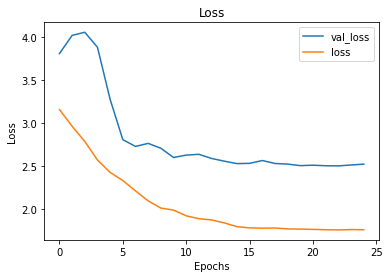

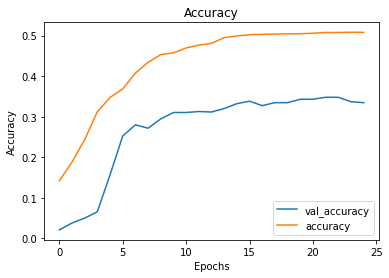

In [51]:
#baseline results
visualize_training_results(baseline_results)

# *EDIT SOURCE TITLE*

### From BirdCLEF2021: Model Training

In [52]:
tf.random.set_seed(RANDOM_SEED)

model = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(len(LABELS), activation='softmax')
])

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 46, 126, 16)       160       
_________________________________________________________________
batch_normalization_4 (Batch (None, 46, 126, 16)       64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 63, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 61, 32)        4640      
_________________________________________________________________
batch_normalization_5 (Batch (None, 21, 61, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 30, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 28, 64)        

In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy'])

In [55]:
# Let's train the model for a few epochs
model_2_results = model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=25)

Epoch 1/25
104/104 [==============================] - 2s 9ms/step - loss: 3.4168 - accuracy: 0.0888 - val_loss: 3.2884 - val_accuracy: 0.0582
Epoch 2/25
104/104 [==============================] - 1s 7ms/step - loss: 2.9420 - accuracy: 0.1637 - val_loss: 3.4294 - val_accuracy: 0.0594
Epoch 3/25
104/104 [==============================] - 1s 7ms/step - loss: 2.6645 - accuracy: 0.2398 - val_loss: 3.3381 - val_accuracy: 0.0630

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/25
104/104 [==============================] - 1s 7ms/step - loss: 2.4221 - accuracy: 0.3042 - val_loss: 3.1626 - val_accuracy: 0.0739
Epoch 5/25
104/104 [==============================] - 1s 7ms/step - loss: 2.3159 - accuracy: 0.3322 - val_loss: 2.6720 - val_accuracy: 0.2121
Epoch 6/25
104/104 [==============================] - 1s 7ms/step - loss: 2.2086 - accuracy: 0.3741 - val_loss: 2.3412 - val_accuracy: 0.3067
Epoch 7/25
104/104 [==============================] - 1s 7ms/step -

In [56]:
train_scores = model.evaluate(train_specs, train_labels)
test_scores = model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

26/26 [==============================] - 0s 3ms/step - loss: 1.4759 - accuracy: 0.6206
Loss of the training model: 0.50
Training Accuracy: 89.66%


Loss of the testing model: 1.48
Test Accuracy: 62.06%


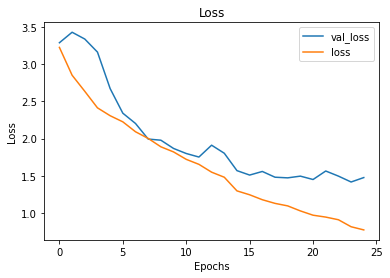

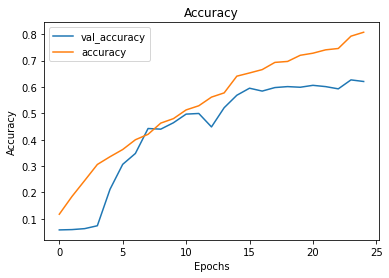

In [57]:
visualize_training_results(model_2_results)

## Seth Adams LSTM

In [58]:
N_CLASSES = len(le_name_mapping)

In [59]:
tf.random.set_seed(RANDOM_SEED)

lstm = Sequential()

lstm.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                 input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1))),
lstm.add(LayerNormalization(axis=2, name='layer_norm'))
lstm.add(TimeDistributed(layers.Reshape((-1,)), name='reshape'))
lstm.add(TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh'))
lstm.add(Bidirectional(layers.LSTM(32, return_sequences=True)))
lstm.add(layers.Dense(64, activation='relu', name='dense_1_relu'))
lstm.add(MaxPool1D(name='max_pool_2d'))
lstm.add(Dense(32, activation='relu', name='dense_2_relu'))
lstm.add(Flatten(name='flatten'))
lstm.add(layers.Dropout(rate=0.2, name='dropout'))
lstm.add(Dense(32, activation='relu',
                     activity_regularizer=l2(0.001),
                     name='dense_3_relu'))
lstm.add(Dense(N_CLASSES, activation='softmax', name='softmax'))

Source: [Seth Adams](https://github.com/seth814/Audio-Classification/blob/master/models.py)

In [60]:
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 48, 128, 16)       160       
_________________________________________________________________
layer_norm (LayerNormalizati (None, 48, 128, 16)       256       
_________________________________________________________________
reshape (TimeDistributed)    (None, 48, 2048)          0         
_________________________________________________________________
td_dense_tanh (TimeDistribut (None, 48, 64)            131136    
_________________________________________________________________
bidirectional (Bidirectional (None, 48, 64)            24832     
_________________________________________________________________
dense_1_relu (Dense)         (None, 48, 64)            4160      
_________________________________________________________________
max_pool_2d (MaxPooling1D)   (None, 24, 64)           

In [61]:
lstm.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [62]:
lstm_results = lstm.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=25)

Epoch 1/25
104/104 [==============================] - 5s 20ms/step - loss: 3.2666 - accuracy: 0.0585 - val_loss: 3.2221 - val_accuracy: 0.0739
Epoch 2/25
104/104 [==============================] - 1s 13ms/step - loss: 3.1327 - accuracy: 0.1111 - val_loss: 3.0787 - val_accuracy: 0.1467
Epoch 3/25
104/104 [==============================] - 1s 13ms/step - loss: 2.8745 - accuracy: 0.2021 - val_loss: 2.9054 - val_accuracy: 0.1648
Epoch 4/25
104/104 [==============================] - 2s 15ms/step - loss: 2.5019 - accuracy: 0.3070 - val_loss: 2.8218 - val_accuracy: 0.2218
Epoch 5/25
104/104 [==============================] - 1s 13ms/step - loss: 2.2475 - accuracy: 0.3625 - val_loss: 2.8224 - val_accuracy: 0.2097
Epoch 6/25
104/104 [==============================] - 1s 13ms/step - loss: 1.9600 - accuracy: 0.4662 - val_loss: 2.7735 - val_accuracy: 0.2303
Epoch 7/25
104/104 [==============================] - 1s 13ms/step - loss: 1.6708 - accuracy: 0.5559 - val_loss: 2.9616 - val_accuracy: 0.2255

In [63]:
train_scores = lstm.evaluate(train_specs, train_labels)
test_scores = lstm.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

26/26 [==============================] - 0s 5ms/step - loss: 3.4332 - accuracy: 0.2206
Loss of the training model: 0.63
Training Accuracy: 92.03%


Loss of the testing model: 3.43
Test Accuracy: 22.06%


In [64]:
input_shape = (SPEC_SHAPE[0], SPEC_SHAPE[1], 1)
print(input_shape)

(48, 128, 1)


In [65]:
model = Sequential()
model.add(layers.LSTM(128,input_shape=(SPEC_SHAPE[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(N_CLASSES, activation='softmax'))

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 27)                1755      
Total params: 93,083
Trainable params: 93,083
Non-trainable params: 0
__________________________________________________

In [67]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### DrCapa

In [68]:
model = Sequential()
model.add(Conv1D(64, input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1), kernel_size=5, strides=4, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(4)))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(N_CLASSES, activation='sigmoid'))

model.compile(optimizer = Adam(lr=2e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 48, 31, 64)        384       
_________________________________________________________________
batch_normalization_8 (Batch (None, 48, 31, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 7, 64)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 5, 64)         12352     
_________________________________________________________________
batch_normalization_9 (Batch (None, 12, 5, 64)         256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 3840)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)              

In [70]:
capa_results = model.fit(train_specs, 
          train_labels,
          batch_size=32, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=25)

Epoch 1/25
104/104 [==============================] - 2s 9ms/step - loss: 3.6941 - accuracy: 0.1328 - val_loss: 3.9963 - val_accuracy: 0.0582
Epoch 2/25
104/104 [==============================] - 1s 6ms/step - loss: 2.5128 - accuracy: 0.2628 - val_loss: 6.1131 - val_accuracy: 0.0582
Epoch 3/25
104/104 [==============================] - 1s 6ms/step - loss: 2.1744 - accuracy: 0.3496 - val_loss: 4.5161 - val_accuracy: 0.1030

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.
Epoch 4/25
104/104 [==============================] - 1s 6ms/step - loss: 1.7686 - accuracy: 0.4570 - val_loss: 4.8128 - val_accuracy: 0.0509
Epoch 5/25
104/104 [==============================] - 1s 6ms/step - loss: 1.5422 - accuracy: 0.5456 - val_loss: 3.6202 - val_accuracy: 0.1079
Epoch 6/25
104/104 [==============================] - 1s 6ms/step - loss: 1.3164 - accuracy: 0.6110 - val_loss: 3.0413 - val_accuracy: 0.1939
Epoch 7/25
104/104 [==============================] - 1s 6ms/step -

In [71]:
train_scores = model.evaluate(train_specs, train_labels)
test_scores = model.evaluate(test_specs, test_labels)

print("Loss of the training model: %.2f"%(train_scores[0]))
print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print('\n')
print("Loss of the testing model: %.2f"%(test_scores[0]))
print("Test Accuracy: %.2f%%"%(test_scores[1] * 100))

26/26 [==============================] - 0s 3ms/step - loss: 2.7840 - accuracy: 0.3733
Loss of the training model: 0.24
Training Accuracy: 95.94%


Loss of the testing model: 2.78
Test Accuracy: 37.33%


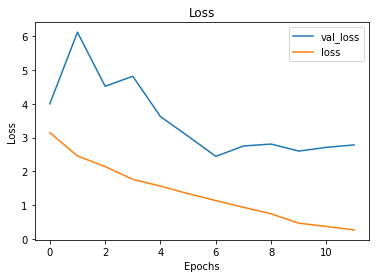

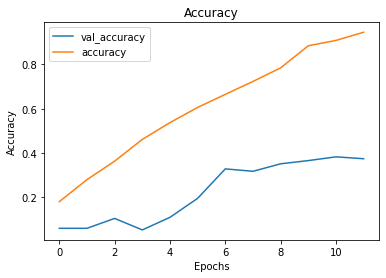

In [73]:
visualize_training_results(capa_results)

## Model Selection

The model type that's been selected for further improvement is ________

## Conclusion

asdffadsfdsa

## References

- [Stefan Kahl](https://www.kaggle.com/stefankahl/birdclef2021-model-training)
- [DrCapa](https://www.kaggle.com/drcapa/birdclef-2021-starter)
- [Andrey Shtrauss](https://www.kaggle.com/shtrausslearning/keras-inference-birdclef2021-starter)
- [Valerio Velardo](https://github.com/musikalkemist/pytorchforaudio/blob/main/08%20Implementing%20a%20CNN%20network/cnn.py)
- [Francois Lemarchand](https://www.kaggle.com/frlemarchand/bird-song-classification-using-an-efficientnet)
- [Seth Adams](https://github.com/seth814/Audio-Classification/blob/master/models.py)
- [Adam Sabra](https://github.com/theadamsabra/InstrumentClassifier)